In [21]:
import numpy as np 
import pandas as pd

In [22]:
import mysql.connector

In [23]:
import os

In [24]:
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'),
    ('order_items.csv','order_items')  # Added payments.csv for specific handling
]

In [25]:
# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='Aknahak@11',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = "D:\eCommerce"

<>:11: SyntaxWarning: invalid escape sequence '\e'
<>:11: SyntaxWarning: invalid escape sequence '\e'
C:\Users\aishw\AppData\Local\Temp\ipykernel_1896\2392744384.py:11: SyntaxWarning: invalid escape sequence '\e'
  folder_path = "D:\eCommerce"


In [26]:
def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

In [27]:
for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector


db = mysql.connector.connect(host = "localhost",
                            username = "root",
                            password = "Aknahak@11",
                            database = "ecommerce")

cur = db.cursor()

 # List all unique cities where customers are located.

In [32]:
query = """ select distinct customer_city from customers """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data)
df.head()

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


# Count the number of orders placed in 2017. 

In [33]:
query = """ select count(order_id) from orders where year(order_purchase_timestamp) = 2017 """

cur.execute(query)

data = cur.fetchall()

"total orders placed in 2017 are", data[0][0]

('total orders placed in 2017 are', 45101)

# Find the total sales per category.

In [34]:
query = """ select upper(products.product_category) category, 
round(sum(payments.payment_value),2) sales
from products join order_items 
on products.product_id = order_items.product_id
join payments 
on payments.order_id = order_items.order_id
group by category
"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["Category", "Sales"])
df

,Category,Sales
0,PERFUMERY,506738.66
1,FURNITURE DECORATION,1430176.39
2,TELEPHONY,486882.05
3,BED TABLE BATH,1712553.67
4,AUTOMOTIVE,852294.33
...,...,...
69,CDS MUSIC DVDS,1199.43
70,LA CUISINE,2913.53
71,FASHION CHILDREN'S CLOTHING,785.67
72,PC GAMER,2174.43


# Calculate the percentage of orders that were paid in installments.


In [37]:
query = """ select ((sum(case when payment_installments >= 1 then 1
else 0 end))/count(*))*100 from payments
"""

cur.execute(query)

data = cur.fetchall()

"the percentage of orders that were paid in installments is", data[0][0]

('the percentage of orders that were paid in installments is',
 Decimal('99.9981'))

# Count the number of customers from each state.

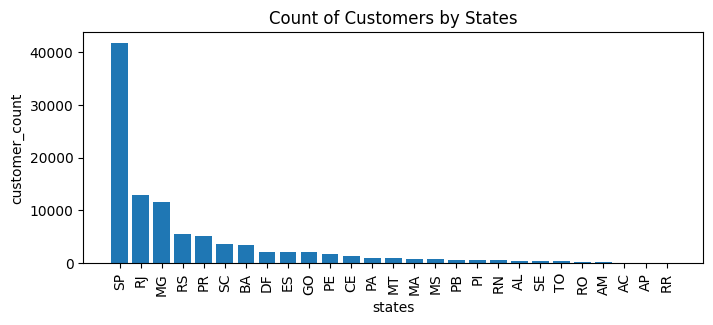

In [38]:
query = """ select customer_state ,count(customer_id)
from customers group by customer_state
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["state", "customer_count" ])
df = df.sort_values(by = "customer_count", ascending= False)

plt.figure(figsize = (8,3))
plt.bar(df["state"], df["customer_count"])
plt.xticks(rotation = 90)
plt.xlabel("states")
plt.ylabel("customer_count")
plt.title("Count of Customers by States")
plt.show()

# Calculate the number of orders per month in 2018.

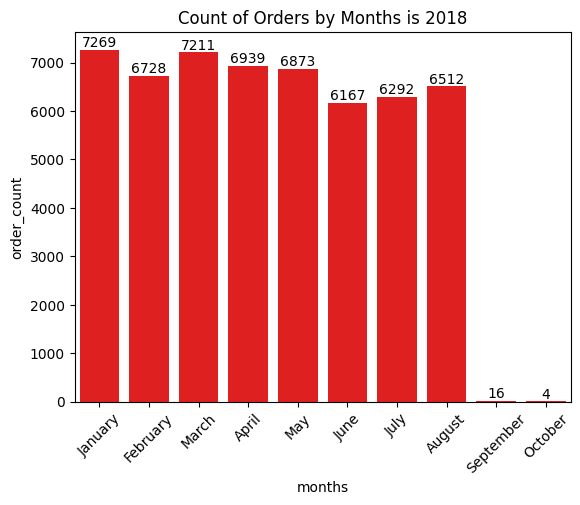

In [39]:
query = """ select monthname(order_purchase_timestamp) months, count(order_id) order_count
from orders where year(order_purchase_timestamp) = 2018
group by months
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["months", "order_count"])
o = ["January", "February","March","April","May","June","July","August","September","October"]

ax = sns.barplot(x = df["months"],y =  df["order_count"], data = df, order = o, color = "red")
plt.xticks(rotation = 45)
ax.bar_label(ax.containers[0])
plt.title("Count of Orders by Months is 2018")

plt.show()

# Find the average number of products per order, grouped by customer city.

In [40]:
query = """with count_per_order as 
(select orders.order_id, orders.customer_id, count(order_items.order_id) as oc
from orders join order_items
on orders.order_id = order_items.order_id
group by orders.order_id, orders.customer_id)

select customers.customer_city, round(avg(count_per_order.oc),2) average_orders
from customers join count_per_order
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city order by average_orders desc
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data,columns = ["customer city", "average products/order"])
df.head(10)

,customer city,average products/order
0,padre carvalho,7.00
1,celso ramos,6.50
2,datas,6.00
3,candido godoi,6.00
4,matias olimpio,5.00
5,cidelandia,4.00
6,picarra,4.00
7,morro de sao paulo,4.00
8,teixeira soares,4.00
9,curralinho,4.00


# Calculate the percentage of total revenue contributed by each product category.

In [41]:
query = """select upper(products.product_category) category, 
round((sum(payments.payment_value)/(select sum(payment_value) from payments))*100,2) sales_percentage
from products join order_items 
on products.product_id = order_items.product_id
join payments 
on payments.order_id = order_items.order_id
group by category order by sales_percentage desc"""


cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Category", "percentage distribution"])
df.head()

,Category,percentage distribution
0,BED TABLE BATH,10.70
1,HEALTH BEAUTY,10.35
2,COMPUTER ACCESSORIES,9.90
3,FURNITURE DECORATION,8.93
4,WATCHES PRESENT,8.93


# Identify the correlation between product price and the number of times a product has been purchased.

In [43]:
cur = db.cursor()
query = """select products.product_category, 
count(order_items.product_id),
round(avg(order_items.price),2)
from products join order_items
on products.product_id = order_items.product_id
group by products.product_category"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Category", "order_count","price"])

arr1 = df["order_count"]
arr2 = df["price"]

a = np.corrcoef([arr1,arr2])
print("the correlation is", a[0][-1])

the correlation is -0.10631514167157562


# Calculate the total revenue generated by each seller, and rank them by revenue.

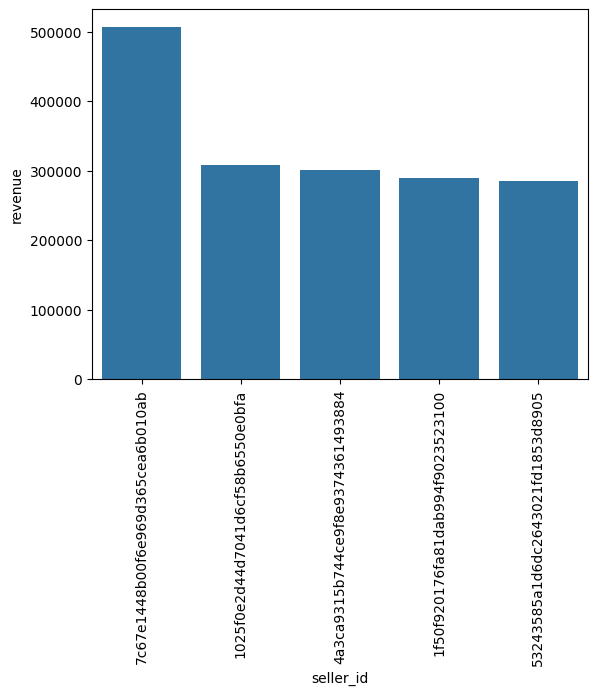

In [42]:
query = """ select *, dense_rank() over(order by revenue desc) as rn from
(select order_items.seller_id, sum(payments.payment_value)
revenue from order_items join payments
on order_items.order_id = payments.order_id
group by order_items.seller_id) as a """

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["seller_id", "revenue", "rank"])
df = df.head()
sns.barplot(x = "seller_id", y = "revenue", data = df)
plt.xticks(rotation = 90)
plt.show()